In [1]:
# --- 0. Setup and Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

In [2]:
# --- 1. Data Pre-processing Operations ---

print("--- 1. Data Pre-processing Operations ---")

# Load the dataset
try:
    loc = r"D:\corizo project 2.csv"
    df = pd.read_csv(loc)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'corizo project 2.csv' not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file is not found

# Display initial information
print("\nInitial DataFrame Info:")
df.info()

print("\nFirst 5 rows of the dataset:")
print(df.head())

# Handle missing values (check for NaNs)
print("\nChecking for missing values:")
print(df.isnull().sum())
# No significant missing values observed in the provided context, but good practice to check.

# Data Type Conversion
print("\nConverting data types...")
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')

# Feature Engineering
df['release_year'] = df['track_album_release_date'].dt.year
df['duration_sec'] = df['duration_ms'] / 1000

# Drop irrelevant columns for the core recommendation logic
# Keep track_name, track_artist, track_popularity for display/context
# Keep playlist_genre, playlist_subgenre for clustering analysis
columns_to_drop = [
    'track_id', 'track_album_id', 'playlist_id',
    'track_album_release_date', 'duration_ms'
]
df_processed = df.drop(columns=columns_to_drop)

print("\nDataFrame after initial processing and feature engineering:")
df_processed.info()
print(df_processed.head())

# Identify numerical features for scaling
numerical_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_sec', 'track_popularity'
]

# Check if all numerical features exist in the DataFrame
missing_num_features = [col for col in numerical_features if col not in df_processed.columns]
if missing_num_features:
    print(f"\nWarning: The following numerical features are missing and will be skipped: {missing_num_features}")
    numerical_features = [col for col in numerical_features if col in df_processed.columns]

# Handle potential non-numeric values in numerical columns (e.g., 'key' might be mixed type if not clean)
for col in numerical_features:
    if df_processed[col].dtype == 'object':
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        print(f"Coerced column '{col}' to numeric.")

# Drop rows with NaN values that might have resulted from coercion (if any)
df_processed.dropna(subset=numerical_features, inplace=True)
print(f"\nDataFrame shape after dropping rows with NaN in numerical features: {df_processed.shape}")


# Scale numerical features
scaler = MinMaxScaler()
df_scaled_features = df_processed[numerical_features].copy()
df_scaled_features[numerical_features] = scaler.fit_transform(df_scaled_features[numerical_features])

# Combine scaled features with categorical/identifier columns
df_final = df_processed.copy()
df_final[numerical_features] = df_scaled_features[numerical_features]

print("\nDataFrame after scaling numerical features:")
print(df_final.head())

# Store the numerical features for clustering and similarity calculations
features_for_clustering = numerical_features

--- 1. Data Pre-processing Operations ---
Dataset loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy              

--- Generating Data Visualizations ---


C:\Users\bhand\AppData\Local\Temp\ipykernel_18896\1876429105.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='playlist_genre', data=df, order=df['playlist_genre'].value_counts().index, palette='viridis')


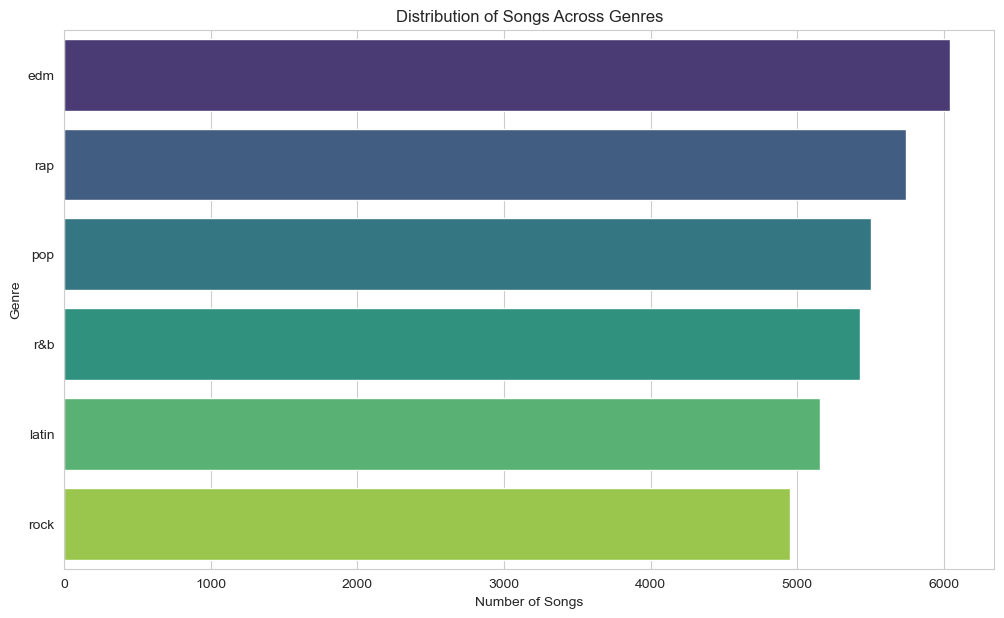

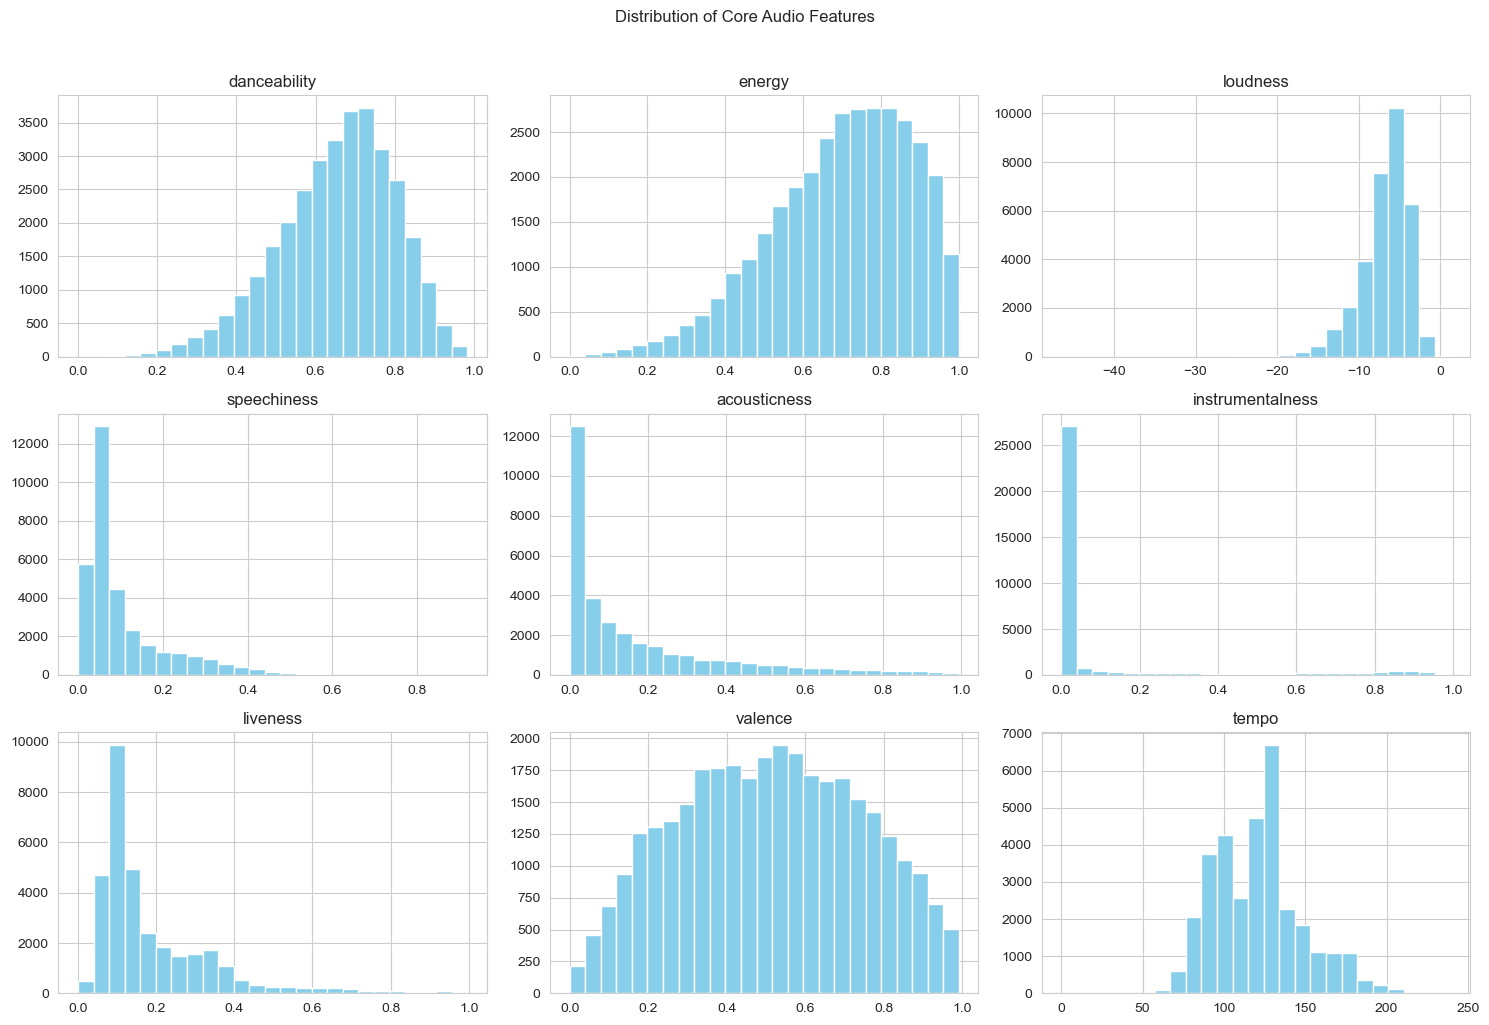

Visualization Complete.



In [3]:
# --- 2. Data Analysis and Visualizations ---

print("--- Generating Data Visualizations ---")
# Set the visual style for the plots
sns.set_style("whitegrid")

# Plot 1: Distribution of songs across different genres
plt.figure(figsize=(12, 7))
sns.countplot(y='playlist_genre', data=df, order=df['playlist_genre'].value_counts().index, palette='viridis')
plt.title('Distribution of Songs Across Genres')
plt.xlabel('Number of Songs')
plt.ylabel('Genre')
plt.show()

# Plot 2: Distribution of key audio features
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df[audio_features].hist(bins=25, figsize=(15, 10), layout=(3, 3), color='skyblue')
plt.suptitle('Distribution of Core Audio Features', y=1.02)
plt.tight_layout()
plt.show()
print("Visualization Complete.\n")


--- 3. Correlation Matrix of Features ---


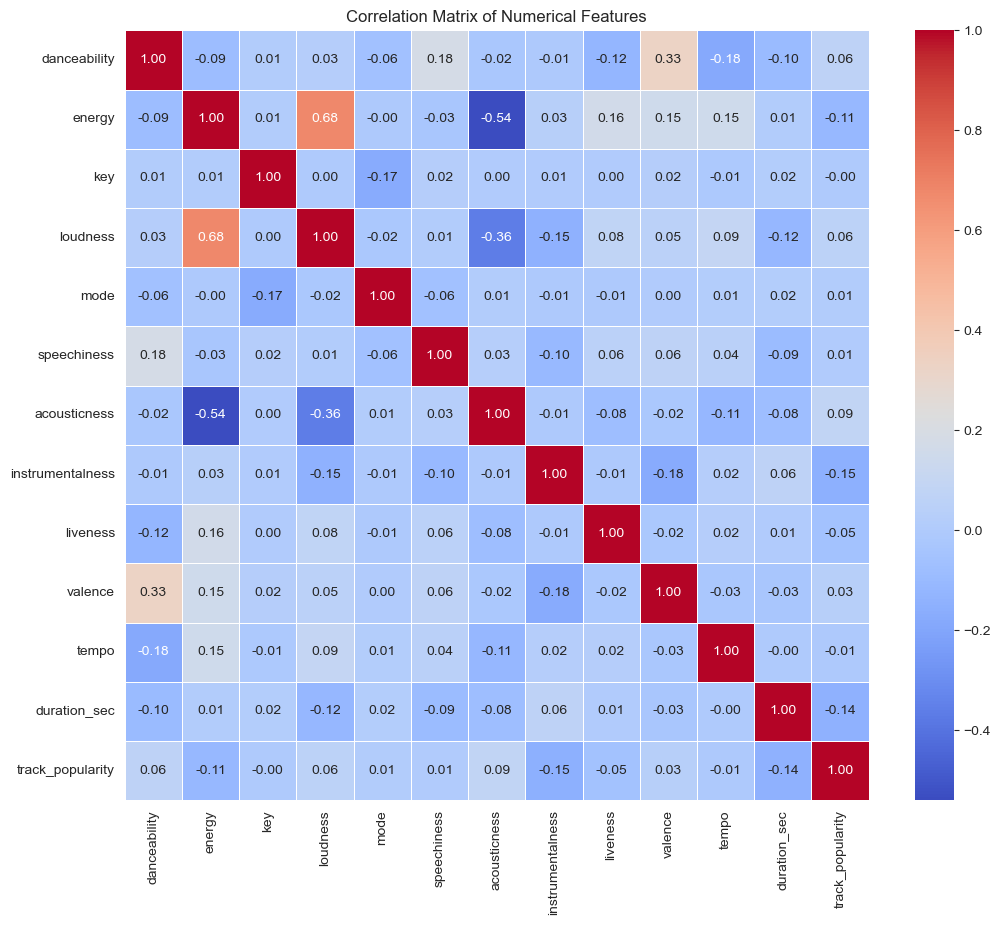

In [4]:
# --- 3. Correlation Matrix of Features ---

print("\n--- 3. Correlation Matrix of Features ---")

# Calculate correlation matrix for numerical features
correlation_matrix = df_final[numerical_features].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


--- 4. Clustering Analysis ---
Determining optimal K for KMeans (Elbow Method)...


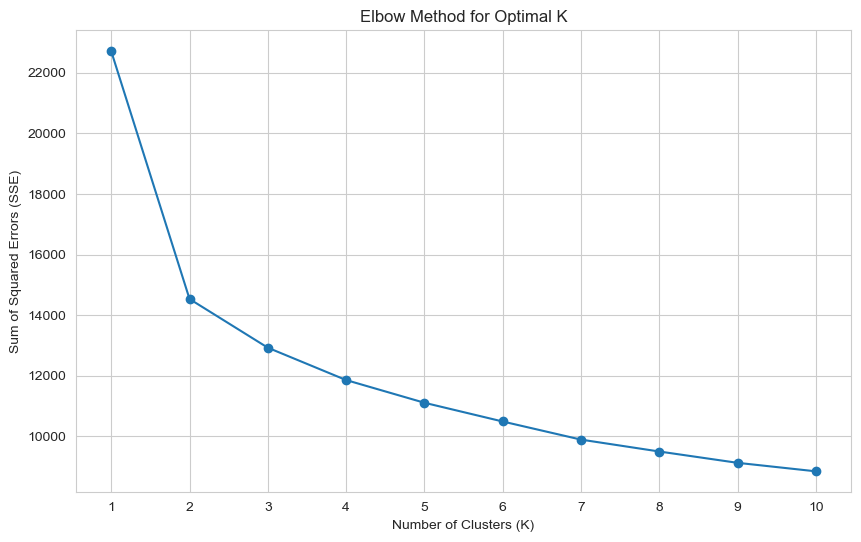


Applying KMeans with optimal K = 5

DataFrame with assigned clusters:
                                          track_name      track_artist  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...        Ed Sheeran   
1                    Memories - Dillon Francis Remix          Maroon 5   
2                    All the Time - Don Diablo Remix      Zara Larsson   
3                  Call You Mine - Keanu Silva Remix  The Chainsmokers   
4            Someone You Loved - Future Humans Remix     Lewis Capaldi   

   track_popularity                                   track_album_name  \
0              0.66  I Don't Care (with Justin Bieber) [Loud Luxury...   
1              0.67                    Memories (Dillon Francis Remix)   
2              0.70                    All the Time (Don Diablo Remix)   
3              0.60                        Call You Mine - The Remixes   
4              0.69            Someone You Loved (Future Humans Remix)   

  playlist_name playlist_genre playlist

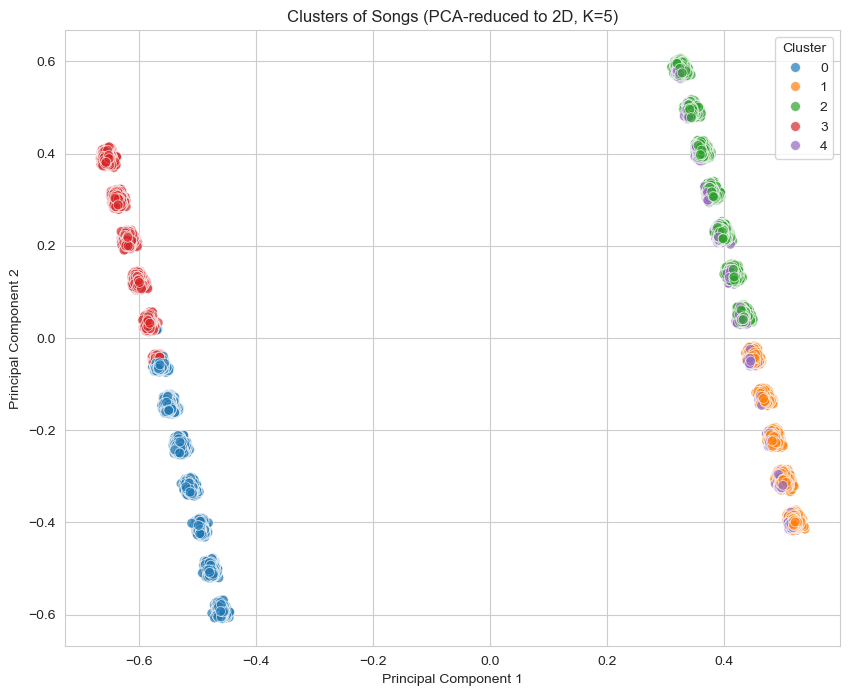


Analyzing cluster composition by Playlist Genre:
playlist_genre       edm     latin       pop       r&b       rap      rock
cluster                                                                   
0               0.221929  0.147675  0.160444  0.182929  0.177099  0.109924
1               0.137712  0.155148  0.178567  0.162658  0.173094  0.192822
2               0.133407  0.172345  0.181527  0.165044  0.153097  0.194580
3               0.184434  0.169266  0.157641  0.181599  0.208959  0.098100
4               0.509839  0.071556  0.116279  0.036971  0.150268  0.115086


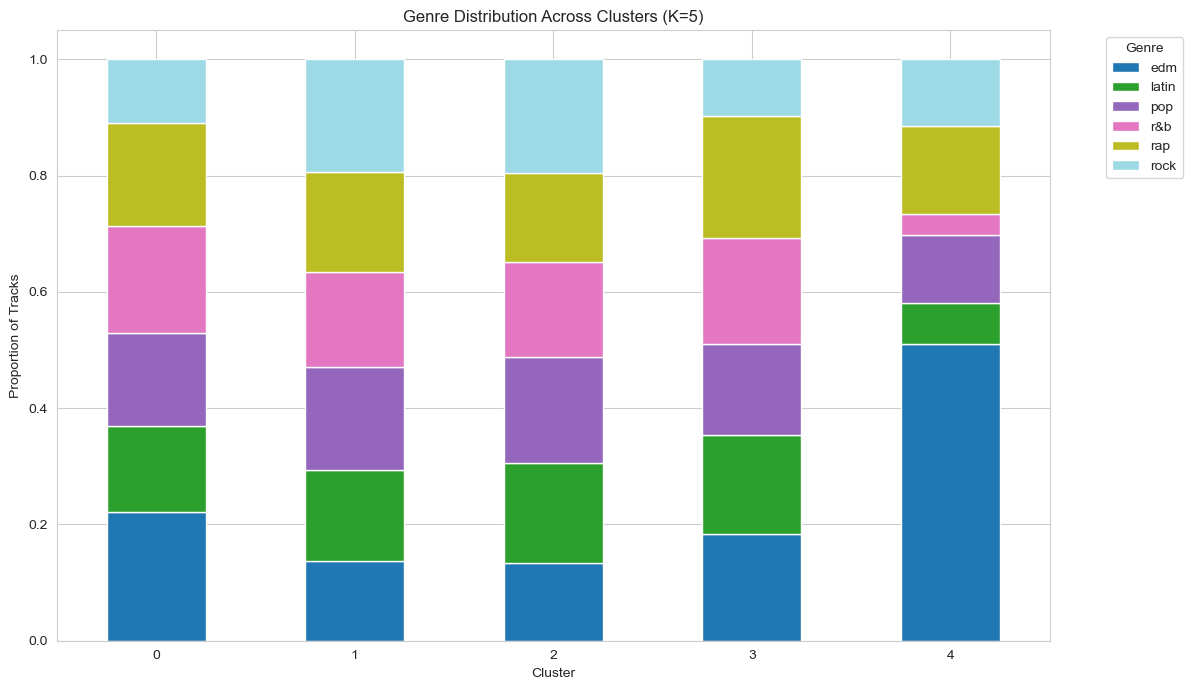


Analyzing cluster composition by Playlist Name (Top 5 per cluster):

--- Cluster 0 ---
playlist_name
Hard Rock Workout                                                                                62
Fitness Workout Electro | House | Dance | Progressive House                                      60
Indie Poptimism                                                                                  51
Urban Contemporary                                                                               49
Charts 2020 🔥Top 2020🔥Hits 2020🔥Summer 2020🔥Pop 2020🔥Popular Music🔥Clean Pop 2020🔥Sing Alongs    47
Name: count, dtype: int64

--- Cluster 1 ---
playlist_name
Indie Poptimism                                                                           90
Ultimate Indie Presents... Best Indie Tracks of the 2010s                                 74
2020 Hits & 2019  Hits – Top Global Tracks 🔥🔥🔥                                            72
Permanent Wave                                              

In [5]:
# --- 4. Find out and plot different clusters ---

print("\n--- 4. Clustering Analysis ---")

# Prepare data for clustering (only numerical features)
X = df_final[features_for_clustering]

# Determine optimal K using Elbow Method
# This can be computationally intensive for very large datasets
print("Determining optimal K for KMeans (Elbow Method)...")
sse = []
k_range = range(1, 11) # Test K from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init to suppress warning
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.show()

# Based on the elbow plot, choose an optimal K. Let's assume K=4 or K=5 for demonstration.
# You might need to adjust this based on your specific plot.
optimal_k = 5 # Example: Choose 5 based on a hypothetical elbow point

print(f"\nApplying KMeans with optimal K = {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_final['cluster'] = kmeans.fit_predict(X)

print("\nDataFrame with assigned clusters:")
print(df_final.head())
print(df_final['cluster'].value_counts())

# Visualize clusters using PCA for dimensionality reduction
print("\nVisualizing clusters using PCA...")
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_final['cluster'].values # Ensure alignment

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='tab10', s=50, alpha=0.7)
plt.title(f'Clusters of Songs (PCA-reduced to 2D, K={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Analyze clusters by Playlist Genre
print("\nAnalyzing cluster composition by Playlist Genre:")
cluster_genre_distribution = df_final.groupby('cluster')['playlist_genre'].value_counts(normalize=True).unstack(fill_value=0)
print(cluster_genre_distribution)

# Plotting cluster composition by genre
cluster_genre_distribution.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='tab20')
plt.title(f'Genre Distribution Across Clusters (K={optimal_k})')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Tracks')
plt.xticks(rotation=0)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analyze clusters by Playlist Name (Top 5 per cluster for brevity)
print("\nAnalyzing cluster composition by Playlist Name (Top 5 per cluster):")
for cluster_id in sorted(df_final['cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    top_playlists = df_final[df_final['cluster'] == cluster_id]['playlist_name'].value_counts().head(5)
    print(top_playlists)

In [8]:
# --- 5. Build your model and show your final result ---

print("\n--- 5. Building the Recommendation Model ---")

# For a content-based recommendation system, we need:
# 1. A way to represent items (songs) by their features. (Already done with df_final[features_for_clustering])
# 2. A similarity metric. (Cosine similarity is good for scaled features)
# 3. A way to get user input (e.g., a liked song).

# Let's create a simplified recommendation function
def recommend_songs(song_name, artist_name, df_data, features, num_recommendations=10):
    # Find the song in the dataset
    song_query = df_data[(df_data['track_name'].str.contains(song_name, case=False, na=False)) &
                          (df_data['track_artist'].str.contains(artist_name, case=False, na=False))]

    if song_query.empty:
        print(f"Song '{song_name}' by '{artist_name}' not found in the dataset.")
        return pd.DataFrame()

    # If multiple matches, take the first one or the most popular one
    if len(song_query) > 1:
        print(f"Multiple matches found for '{song_name}' by '{artist_name}'. Using the most popular version.")
        song_query = song_query.sort_values(by='track_popularity', ascending=False).iloc[[0]]

    target_song_features = song_query[features].values
    target_song_name = song_query['track_name'].iloc[0]
    target_song_artist = song_query['track_artist'].iloc[0]

    print(f"\nRecommending songs similar to: '{target_song_name}' by '{target_song_artist}'")

    # Calculate similarity with all other songs
    # Exclude the target song itself from the similarity calculation
    other_songs = df_data[~((df_data['track_name'] == target_song_name) &
                            (df_data['track_artist'] == target_song_artist))]

    similarities = cosine_similarity(target_song_features, other_songs[features])

    # Get indices of top similar songs
    # similarities is a 2D array, take the first row
    similar_indices = similarities.argsort()[0][::-1] # Sort in descending order

    # Get the top N recommendations
    recommendations = other_songs.iloc[similar_indices[:num_recommendations]]

    # Display recommendations
    print(f"\nTop {num_recommendations} Recommendations:")
    return recommendations[['track_name', 'track_artist', 'track_popularity', 'playlist_genre', 'playlist_subgenre']]


--- 5. Building the Recommendation Model ---


In [7]:
# --- Final Result Demonstration ---

print("\n--- Final Result Demonstration ---")

# Example 1: Recommend songs similar to a popular track
recommended_songs_df = recommend_songs(song_name="I Don't Care (with Justin Bieber) - Loud Luxury Remix",
                                       artist_name="Ed Sheeran",
                                       df_data=df_final,
                                       features=features_for_clustering,
                                       num_recommendations=10)
print(recommended_songs_df)

# Example 2: Recommend songs similar to another track
recommended_songs_df_2 = recommend_songs(song_name="Memories - Dillon Francis Remix",
                                         artist_name="Maroon 5",
                                         df_data=df_final,
                                         features=features_for_clustering,
                                         num_recommendations=5)
print(recommended_songs_df_2)

# Example 3: Recommend songs similar to a less popular track (if available)
recommended_songs_df_3 = recommend_songs(song_name="Let It Be Me - Sondr Remix",
                                         artist_name="Steve Aoki",
                                         df_data=df_final,
                                         features=features_for_clustering,
                                         num_recommendations=5)
print(recommended_songs_df_3)

# Example 4: Demonstrate user taste profile recommendation (conceptual)
# In a real system, you'd get a list of songs liked by a user.
# Here, we'll simulate by taking a few songs and averaging their features.

print("\n--- Conceptual User Taste Profile Recommendation ---")

# Simulate a user's liked songs (using existing songs from the dataset)
user_liked_songs = df_final[df_final['track_name'].isin([
    "I Don't Care (with Justin Bieber) - Loud Luxury Remix",
    "All the Time - Don Diablo Remix",
    "Beautiful People (feat. Khalid) - Jack Wins Remix"
])].copy()

if not user_liked_songs.empty:
    user_taste_profile = user_liked_songs[features_for_clustering].mean().values.reshape(1, -1)
    print("\nSimulated User Taste Profile (average features of liked songs):")
    print(pd.DataFrame(user_taste_profile, columns=features_for_clustering))

    # Calculate similarity of this profile with all songs in the dataset
    # Exclude the liked songs themselves from recommendations
    all_other_songs = df_final[~df_final['track_name'].isin(user_liked_songs['track_name'])]

    profile_similarities = cosine_similarity(user_taste_profile, all_other_songs[features_for_clustering])
    profile_similar_indices = profile_similarities.argsort()[0][::-1]

    user_recommendations = all_other_songs.iloc[profile_similar_indices[:10]]

    print("\nTop 10 Recommendations based on User Taste Profile:")
    print(user_recommendations[['track_name', 'track_artist', 'track_popularity', 'playlist_genre', 'playlist_subgenre']])
else:
    print("Could not simulate user taste profile as liked songs were not found.")

print("\n--- End of Recommendation System Demonstration ---")


--- Final Result Demonstration ---
Song 'I Don't Care (with Justin Bieber) - Loud Luxury Remix' by 'Ed Sheeran' not found in the dataset.
Empty DataFrame
Columns: []
Index: []
Multiple matches found for 'Memories - Dillon Francis Remix' by 'Maroon 5'. Using the most popular version.

Recommending songs similar to: 'Memories - Dillon Francis Remix' by 'Maroon 5'

Top 5 Recommendations:
            track_name  track_artist  track_popularity playlist_genre  \
23667        Arrogante         Irama              0.69            r&b   
20110    Kiss Somebody  Julie Bergan              0.72          latin   
19217  Robarte un Beso  Carlos Vives              0.76          latin   
17947  Robarte un Beso  Carlos Vives              0.76          latin   
20371  Robarte un Beso  Carlos Vives              0.76          latin   

      playlist_subgenre  
23667           hip pop  
20110     latin hip hop  
19217         reggaeton  
17947         latin pop  
20371     latin hip hop  


C:\Users\bhand\AppData\Local\Temp\ipykernel_18896\2260025078.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  song_query = df_data[(df_data['track_name'].str.contains(song_name, case=False, na=False)) &



Recommending songs similar to: 'Let It Be Me - Sondr Remix' by 'Steve Aoki'

Top 5 Recommendations:
                                 track_name    track_artist  track_popularity  \
32773  Just One Last Time (feat. Taped Rai)    David Guetta              0.41   
29882                             Fly Again    Leo Dynamic1              0.38   
30782                Straight Into The Fire            Zedd              0.43   
30788                       Nothing To Hide  Boombox Cartel              0.47   
14781                       Black Flag Army        HELLYEAH              0.44   

      playlist_genre          playlist_subgenre  
32773            edm  progressive electro house  
29882            edm                    pop edm  
30782            edm                    pop edm  
30788            edm                    pop edm  
14781           rock                  hard rock  

--- Conceptual User Taste Profile Recommendation ---

Simulated User Taste Profile (average features of liked s